# WISE derived soil properties on a 30 by 30 arc-seconds global grid

**Overview**: https://data.isric.org/geonetwork/srv/eng/catalog.search#/metadata/dc7b283a-8f19-45e1-aaed-e9bd515119bc

**Data files**: https://files.isric.org/public/wise/wise_30sec_v1.zip

In [3]:
import os
import pandas as pd
import numpy as np
import rasterio as rio

### function to create soil raster from mapping unit and soil prop table

In [4]:
def write_prop_raster(data_path, smu_raster, soil_df, prop_col, prop_raster):
  
    # read smu_raster
    with rio.open(os.path.join(data_path, smu_raster)) as src:
      smu_raster = src.read().squeeze()
      metadata = src.meta
      
    # convert raster to df
    smu_df = pd.DataFrame(smu_raster.flatten(), columns=['IDSMU'])
    
    # join to tabular data
    merged_df = pd.merge(smu_df, soil_df, on='IDSMU', how='left')
    
    # reconstruct raster
    soil_prop_raster = merged_df[[prop_col]].to_numpy().reshape(metadata['height'], metadata['width'])
    
    # update metadata with soil property dtype
    prop_dtype = soil_df[prop_col].dtype
  
    if prop_dtype == float:
      metadata['dtype'] = 'float32' #rasterio does not support float16
      metadata['nodata'] = np.nan
    else:
      metadata['dtype'] = 'int8' #handles drainage class (valid range 1-7)
      metadata['nodata'] = 0
      
    # set nodata values and compression
    metadata['compress'] = 'LZW'
    
    # assign metadata and write file
    with rio.open(prop_raster, 'w', **metadata) as dst:
      dst.write(soil_prop_raster, 1)

## drainage class

- group by class/category
- add proportion of components with similar class to calculate new proportion Value
- get index of max proportion and assign as drainage class for mapping unit
- note valid drainage class values are 1,2,3,4,5,6,7

In [5]:
def get_soil_Drainage(data_path, data_file):

    soil_csv = os.path.join(data_path, data_file)
    
    # read textfile
    # soil_df = pd.read_csv(soil_csv, header=0)
    soil_df = pd.read_csv(soil_csv, sep=',', header=0)
    soil_df["IDSMU"] = soil_df["NEWSUID"].str[3:].astype(int)
    soil_df = soil_df.rename(columns={"SCID" : "IDSTU"})

    # skip layers deeper than 1 meter
    soil_df = soil_df[soil_df["BotDep"] <= 100]
    
    # skip records with suid 0, 6997, 6998
    soil_df = soil_df[~soil_df["IDSMU"].isin([0, 6997, 6998])]

    sel_props = ["DrainNum"] # unique values [ 6  4  5  3  2  7 -9  1]

    # skip records with drainage class -9
    soil_df = soil_df[~soil_df["DrainNum"].isin([-9])]

    soil_df = soil_df[["IDSMU", "IDSTU", "PROP", "TopDep", "BotDep"] + sel_props]
    soil_df = soil_df.groupby(["IDSMU", "IDSTU", "PROP", "DrainNum"]).agg(ROOTING_DEPTH=("BotDep", "max")).reset_index()

    # ignore ROOTING_DEPTH < 30
    soil_df = soil_df[soil_df["ROOTING_DEPTH"] >= 30]
    soil_df = soil_df.groupby(["IDSMU", "DrainNum"]).agg(COMBINED_PROP=("PROP", "sum")).reset_index()

    # index of rows with maximum PROP value within each group
    max_prop_index = soil_df.groupby('IDSMU')['COMBINED_PROP'].idxmax()
    
    soil_df = soil_df.loc[max_prop_index, ['IDSMU', 'DrainNum']]
    
    return soil_df[["IDSMU", "DrainNum"]]


## awc

In [51]:
def get_soil_AWC(data_path, data_file):
    """
    Original query to get available water capacity:
    select
        to_number(substr(newsuid,4))                  idsmu
      , scid                                          idstu
      , prop                                          percentage
      , max(botdep)                                   soil_rooting_depth
      , sum(tawcc*(botdep-topdep))/sum(botdep-topdep) available_water_capacity
    from
      (select
          newsuid              newsuid    -- soil map unit id
        , scid                 scid       -- soil type id       
        , prop                 prop       -- proportion of soil type in map unit
        , topdep               topdep     -- top depth of layer
        , botdep               botdep     -- bottom depth of layer      
        , (1-(cfrag/100))*tawc tawcc      -- tawc corrected for coarse fragments > 2mm
      from hw30s_full
      where botdep <= 100                  -- skip layers deeper than 1 meter
      and   tawc   >= 0                    -- skip records with -1, -2, -3, -4, -5, -7, -9
      and   to_number(substr(newsuid,4)) not in (0,6997,6998) -- skip records with suid 0, 6997, 6998
    )
    group by to_number(substr(newsuid,4)), scid, prop
    order by to_number(substr(newsuid,4)), scid, prop;
    """
    soil_csv = os.path.join(data_path, data_file)
    
    # read textfile
    # soil_df = pd.read_csv(soil_csv, header=0)
    soil_df = pd.read_csv(soil_csv, sep=',', header=0)
    soil_df["IDSMU"] = soil_df["NEWSUID"].str[3:].astype(int)
    soil_df = soil_df.rename(columns={"SCID" : "IDSTU"})


    # skip layers deeper than 1 meter (do for all)
    soil_df = soil_df[soil_df["BotDep"] <= 100]
    # skip records TAWC with -1, -2, -3, -4, -5, -7, -9
    soil_df = soil_df[soil_df["TAWC"] >= 0]
    # skip records with suid 0, 6997, 6998 (do for all)
    soil_df = soil_df[~soil_df["IDSMU"].isin([0, 6997, 6998])]
    # TAWC corrected for coarse fragments > 2mm
    soil_df["TAWCC"] = (1-(soil_df["CFRAG"]/100))* soil_df["TAWC"]


    sel_props = ["TAWCC"]
    soil_df = soil_df[["IDSMU", "IDSTU", "PROP", "TopDep", "BotDep"] + sel_props]
    soil_df["DEP_DIFF"] = soil_df["BotDep"] - soil_df["TopDep"]
    soil_df["AWC_NUM"] = soil_df["TAWCC"] * soil_df["DEP_DIFF"]


    soil_df = soil_df.groupby(["IDSMU", "IDSTU", "PROP"]).agg(ROOTING_DEPTH=("BotDep", "max"),
                                                              AWC_NUM=("AWC_NUM", "sum"),
                                                              AWC_DENOM=("DEP_DIFF", "sum")).reset_index()


    soil_df["AWC"] = soil_df["AWC_NUM"] / soil_df["AWC_DENOM"]

    # ignore ROOTING_DEPTH < 30
    soil_df = soil_df[soil_df["ROOTING_DEPTH"] >= 30]


    # aggregate to IDSMU
    soil_df["AWC_x_PROP"] = soil_df["AWC"] * soil_df["PROP"]
    soil_df = soil_df.groupby(["IDSMU"]).agg(AWC_NUM=("AWC_x_PROP", "sum"),
                                             AWC_DENOM=("PROP", "sum")).reset_index()
    soil_df["AWC"] = soil_df["AWC_NUM"] / soil_df["AWC_DENOM"]


    # print(soil_df.sort_values(by=["IDSMU"]).head())
    return soil_df[["IDSMU", "AWC"]]

## pH

In [50]:
def get_soil_pH(data_path, data_file):

    soil_csv = os.path.join(data_path, data_file)
    
    # read textfile
    # soil_df = pd.read_csv(soil_csv, header=0)
    soil_df = pd.read_csv(soil_csv, sep=',', header=0) #*******
    soil_df["IDSMU"] = soil_df["NEWSUID"].str[3:].astype(int)
    soil_df = soil_df.rename(columns={"SCID" : "IDSTU"})

    # skip layers deeper than 1 meter
    soil_df = soil_df[soil_df["BotDep"] <= 100]
    
    # skip records with suid 0, 6997, 6998
    soil_df = soil_df[~soil_df["IDSMU"].isin([0, 6997, 6998])]
    
    sel_props = ["PHAQ"]
    # convert ph to original concentrations
    soil_df["PHAQ"] = 10**(-soil_df["PHAQ"])

    soil_df = soil_df[["IDSMU", "IDSTU", "PROP", "TopDep", "BotDep"] + sel_props]
    soil_df["DEP_DIFF"] = soil_df["BotDep"] - soil_df["TopDep"]
    soil_df["PHAQ_NUM"] = soil_df["PHAQ"] * soil_df["DEP_DIFF"]
    


    soil_df = soil_df.groupby(["IDSMU", "IDSTU", "PROP"]).agg(ROOTING_DEPTH=("BotDep", "max"),
                                                              AWC_DENOM=("DEP_DIFF", "sum"),
                                                              PHAQ_NUM=("PHAQ_NUM", "sum")).reset_index() #******
    

    soil_df["PH"] = soil_df["PHAQ_NUM"] / soil_df["AWC_DENOM"]
    
    # ignore ROOTING_DEPTH < 30
    soil_df = soil_df[soil_df["ROOTING_DEPTH"] >= 30]


    # aggregate to IDSMU
    soil_df["PH_x_PROP"] = soil_df["PH"] * soil_df["PROP"]
    soil_df = soil_df.groupby(["IDSMU"]).agg(PHAQ_NUM=("PH_x_PROP", "sum"),
                                             AWC_DENOM=("PROP", "sum")).reset_index()
    
    soil_df["PH"] = soil_df["PHAQ_NUM"] / soil_df["AWC_DENOM"]

    # convert ph back to log scale
    soil_df["PH"] = -np.log10(soil_df["PH"])

    
    return soil_df[["IDSMU", "PH"]]

In [52]:
data_path = "/app/dev/AgML/soil/WISE30sec/Interchangeable_format"
data_file = "HW30s_FULL.txt"

# prepare soil property
soil_prop_awc = get_soil_AWC(data_path, data_file)
soil_prop_drainage = get_soil_Drainage(data_path, data_file)
soil_prop_ph = get_soil_pH(data_path, data_file)

# write tif
write_prop_raster(data_path, 'wise_30sec_v1.tif', soil_prop_awc, "AWC", '/app/dev/AgML/soil/soil_awc.tif')
write_prop_raster(data_path, 'wise_30sec_v1.tif', soil_prop_drainage, "DrainNum", '/app/dev/AgML/soil/soil_drainage.tif')
write_prop_raster(data_path, 'wise_30sec_v1.tif', soil_prop_ph, "PH", '/app/dev/AgML/soil/soil_ph.tif')

## plot soil properties

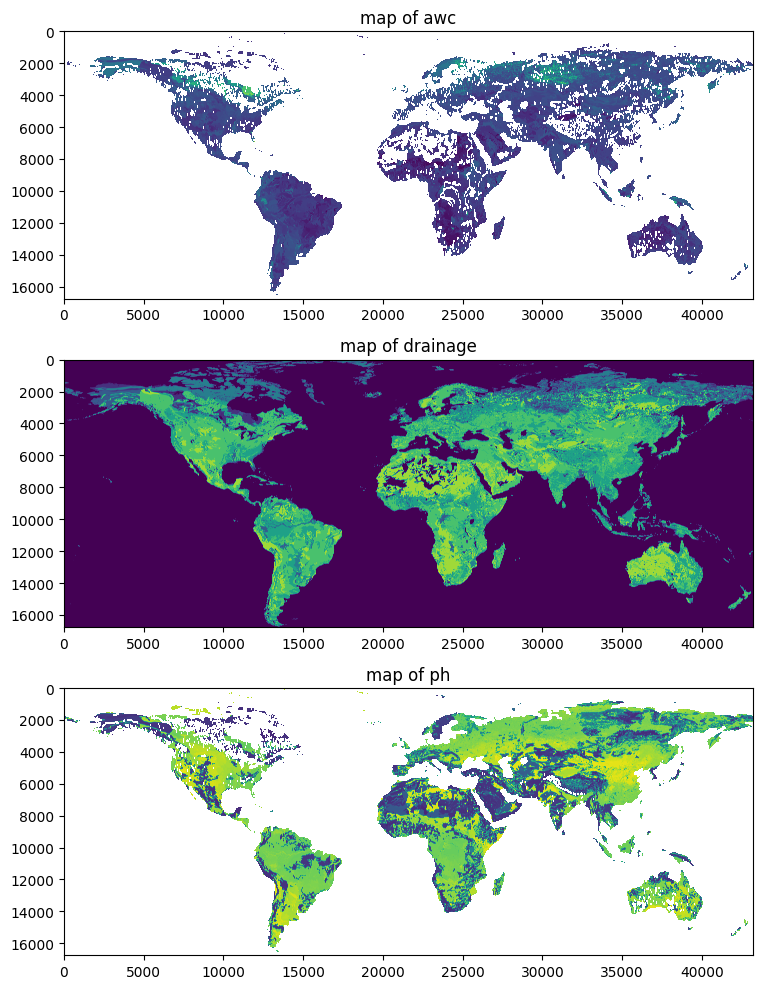

In [55]:
from matplotlib import pyplot as plt

# read awc raster
with rio.open('/app/dev/AgML/soil/soil_awc.tif') as src:
    awc_raster = src.read().squeeze()

# read drainage raster
with rio.open('/app/dev/AgML/soil/soil_drainage.tif') as src:
    drainage_raster = src.read().squeeze()

# read ph raster
with rio.open('/app/dev/AgML/soil/soil_ph.tif') as src:
    ph_raster = src.read().squeeze()


# Create a figure and subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 10))

# Plot data on each subplot
axs[0].imshow(awc_raster)
axs[0].set_title('map of awc')

axs[1].imshow(drainage_raster)
axs[1].set_title('map of drainage')

axs[2].imshow(ph_raster)
axs[2].set_title('map of ph')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()